Using device: cuda


C:\Users\amssa\Documents\Codes\New\Von-Neumann-Entropy-GNN\Random sub sets\Train.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.data, self.slices = torch.load(sel

Model loaded successfully.

Overall Model Performance Metrics:
--------------------------------------------------
Mean Squared Error        : 0.0059
Root Mean Squared Error   : 0.0767
Mean Absolute Error       : 0.0395
R² Score                  : 0.9379
Mean Percentage Error     : 132.5771%
Median Percentage Error   : 4.4122%


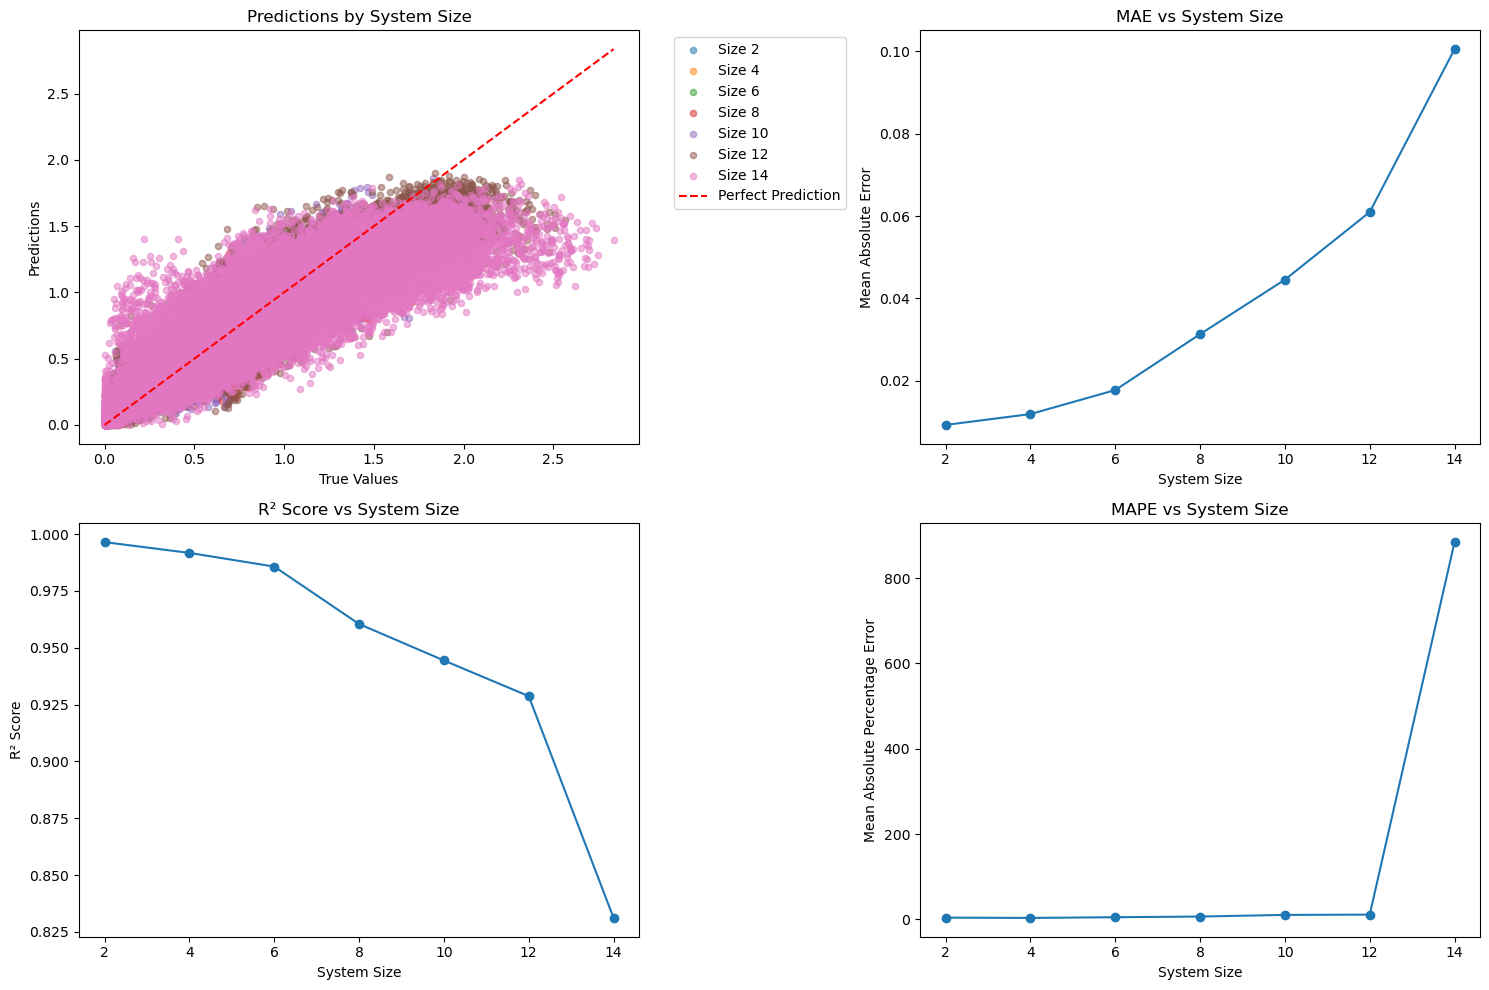


Performance Metrics by System Size:
 System Size  Count    MSE    MAE     R²     MAPE
      2.0000 213794 0.0001 0.0093 0.9965   4.2117
      4.0000 213412 0.0003 0.0119 0.9917   3.4782
      6.0000 214687 0.0008 0.0178 0.9857   5.1455
      8.0000 213927 0.0029 0.0313 0.9605   6.7513
     10.0000 214412 0.0048 0.0445 0.9444  10.5474
     12.0000 214902 0.0087 0.0610 0.9287  11.2196
     14.0000 214866 0.0235 0.1005 0.8312 884.2787


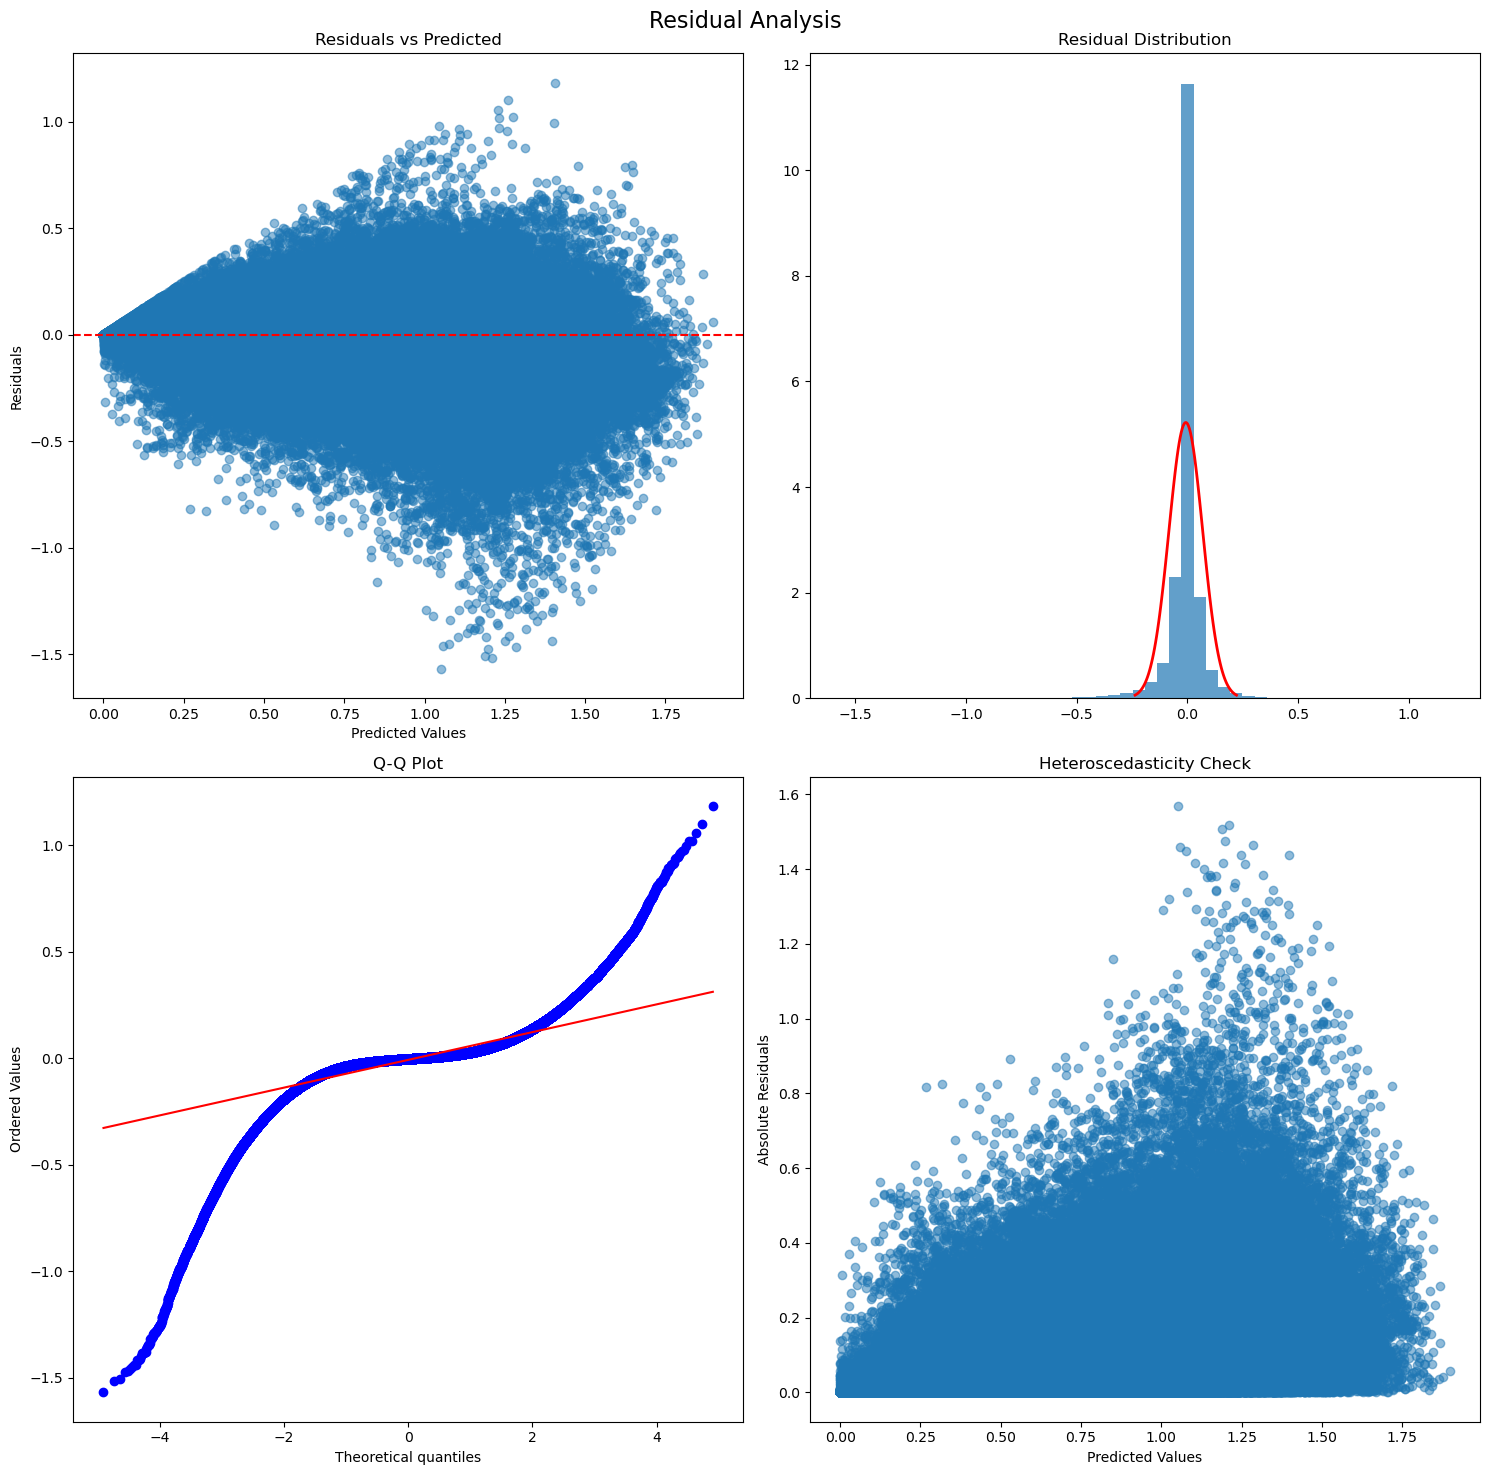

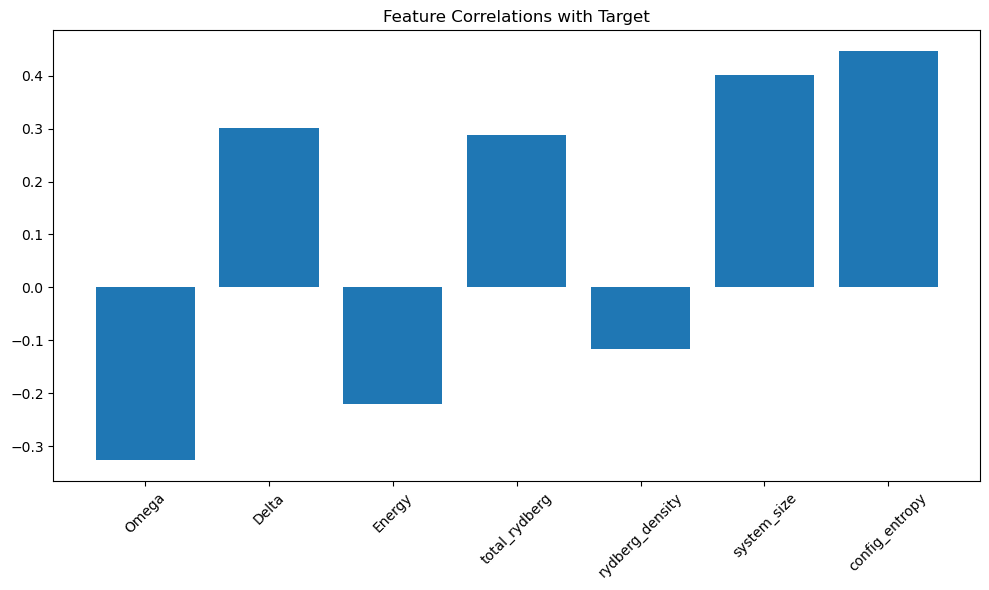

C:\Users\amssa\AppData\Local\Temp\ipykernel_28604\2010681680.py:175: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df.groupby(pd.qcut(df['feature'], q=10, duplicates='drop'))['error'].mean()
C:\Users\amssa\AppData\Local\Temp\ipykernel_28604\2010681680.py:175: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = df.groupby(pd.qcut(df['feature'], q=10, duplicates='drop'))['error'].mean()
C:\Users\amssa\AppData\Local\Temp\ipykernel_28604\2010681680.py:175: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain

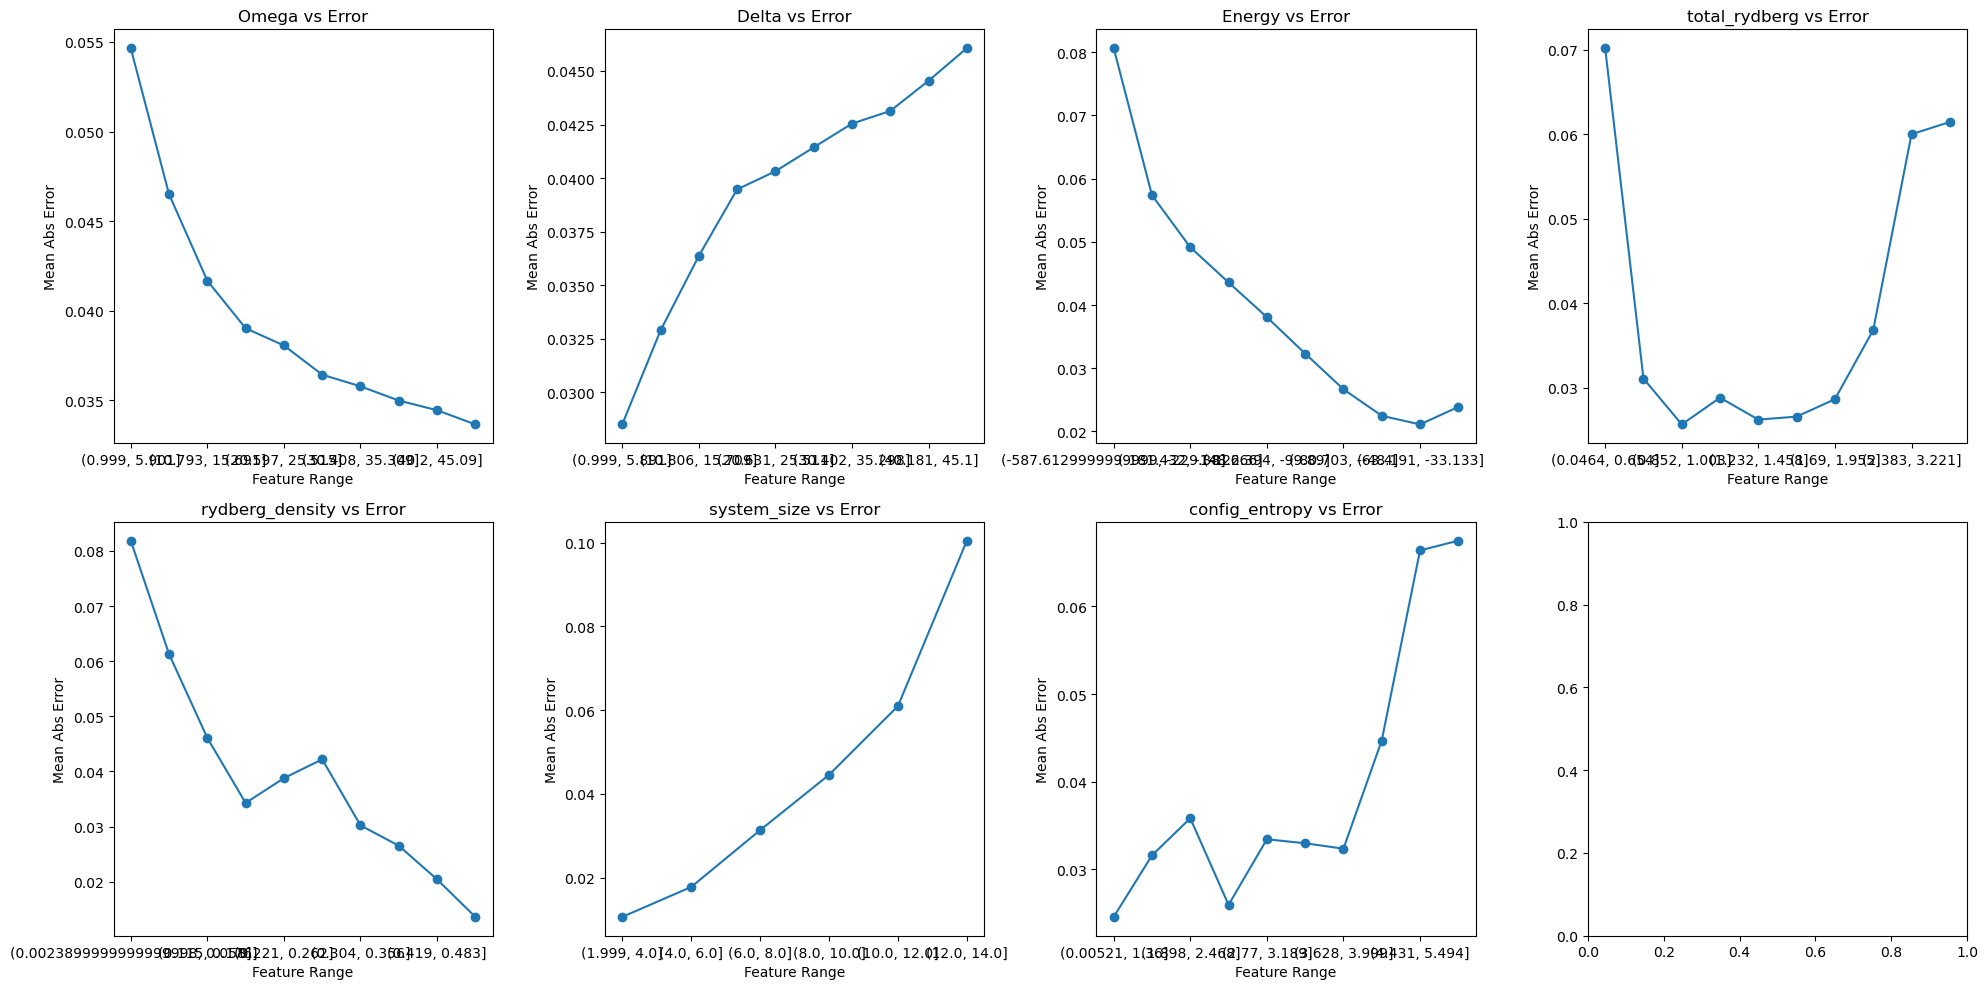


All analyses complete!


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# IMPORTANT: Use loader.DataLoader to avoid the PyG deprecation warning
from torch_geometric.loader import DataLoader
import scipy.stats as stats
from collections import defaultdict
import pandas as pd

# Update these imports to match your new training code:
# For example, if your training code file is named "Train.py" and contains:
#   - ImprovedPhysicsGNN  (instead of PhysicsGNN)
#   - SpinSystemDataset
#   - CONFIG
from Train import ImprovedPhysicsGNN, SpinSystemDataset, CONFIG

def load_trained_model(model_path, dataset, device):
    """Load the trained model and prepare it for evaluation."""
    if len(dataset) == 0:
        raise ValueError("Dataset is empty, cannot instantiate model.")

    sample_data = dataset[0]
    model = ImprovedPhysicsGNN(
        num_node_features=sample_data.x.size(1),
        edge_attr_dim=sample_data.edge_attr.size(1),
        hidden_channels=CONFIG['hidden_channels'],
        dropout_p=CONFIG['dropout_p']
    ).to(device)

    # If you just need state_dict for the model weights, you can do:
    #    state_dict = torch.load(model_path, map_location=device, weights_only=True)
    # Otherwise, if your file includes more than the state_dict, keep it as below.
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def get_predictions(model, loader, device):
    """Get model predictions and actual values."""
    predictions = []
    targets = []
    feature_values = defaultdict(list)
    system_sizes = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            log_pred = model(data)
            # The new code logs the target, so we take exp(...) to get predictions in normal space
            pred = torch.exp(log_pred).cpu().numpy()
            target = data.y.squeeze().cpu().numpy()
            
            predictions.extend(pred)
            targets.extend(target)
            
            # Collect feature values for optional analysis
            feature_values['Omega'].extend(data.Omega.cpu().numpy().flatten())
            feature_values['Delta'].extend(data.Delta.cpu().numpy().flatten())
            feature_values['Energy'].extend(data.Energy.cpu().numpy().flatten())
            feature_values['total_rydberg'].extend(data.total_rydberg.cpu().numpy().flatten())
            feature_values['rydberg_density'].extend(data.rydberg_density.cpu().numpy().flatten())
            feature_values['system_size'].extend(data.system_size.cpu().numpy().flatten())
            feature_values['config_entropy'].extend(data.config_entropy.cpu().numpy().flatten())
            
            system_sizes.extend(data.system_size.cpu().numpy().flatten())
    
    return (np.array(predictions), np.array(targets), 
            feature_values, np.array(system_sizes))

def analyze_system_size_performance(predictions, targets, system_sizes):
    """Analyze model performance across different system sizes."""
    unique_sizes = np.unique(system_sizes)
    size_metrics = []
    
    plt.figure(figsize=(15, 10))
    
    # Calculate metrics for each system size
    for size in unique_sizes:
        mask = system_sizes == size
        size_preds = predictions[mask]
        size_targets = targets[mask]
        
        mse = mean_squared_error(size_targets, size_preds)
        mae = mean_absolute_error(size_targets, size_preds)
        r2 = r2_score(size_targets, size_preds)
        mape = np.mean(np.abs((size_targets - size_preds) / (size_targets + 1e-10))) * 100
        
        size_metrics.append({
            'System Size': size,
            'Count': np.sum(mask),
            'MSE': mse,
            'MAE': mae,
            'R²': r2,
            'MAPE': mape
        })
        
        # Scatter predictions vs targets for each system size
        plt.subplot(2, 2, 1)
        plt.scatter(size_targets, size_preds, alpha=0.5, 
                   label=f'Size {int(size)}', s=20)
    
    plt.subplot(2, 2, 1)
    plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 
             'r--', label='Perfect Prediction')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Predictions by System Size')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    metrics_df = pd.DataFrame(size_metrics)
    
    # Plot MAE vs system size
    plt.subplot(2, 2, 2)
    plt.plot(metrics_df['System Size'], metrics_df['MAE'], 'o-')
    plt.xlabel('System Size')
    plt.ylabel('Mean Absolute Error')
    plt.title('MAE vs System Size')
    
    # Plot R² vs system size
    plt.subplot(2, 2, 3)
    plt.plot(metrics_df['System Size'], metrics_df['R²'], 'o-')
    plt.xlabel('System Size')
    plt.ylabel('R² Score')
    plt.title('R² Score vs System Size')
    
    # Plot MAPE vs system size
    plt.subplot(2, 2, 4)
    plt.plot(metrics_df['System Size'], metrics_df['MAPE'], 'o-')
    plt.xlabel('System Size')
    plt.ylabel('Mean Absolute Percentage Error')
    plt.title('MAPE vs System Size')
    
    plt.tight_layout()
    plt.show()
    
    print("\nPerformance Metrics by System Size:")
    print(metrics_df.to_string(index=False, float_format=lambda x: '{:.4f}'.format(x)))
    
    return metrics_df

def plot_feature_correlations(feature_values, targets):
    """Plot feature correlations with the target."""
    correlations = {}
    for feature_name, values in feature_values.items():
        vals = np.array(values).reshape(-1)
        tars = np.array(targets).reshape(-1)
        min_len = min(len(vals), len(tars))
        vals, tars = vals[:min_len], tars[:min_len]
        
        correlations[feature_name] = np.corrcoef(vals, tars)[0, 1]
    
    plt.figure(figsize=(10, 6))
    plt.bar(correlations.keys(), correlations.values())
    plt.xticks(rotation=45)
    plt.title('Feature Correlations with Target')
    plt.tight_layout()
    plt.show()
    
    return correlations

def plot_error_by_feature_range(feature_values, predictions, targets):
    """Plot the mean absolute error across different ranges of each feature."""
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    errors = np.abs(predictions - targets)
    
    for idx, (feature_name, values) in enumerate(feature_values.items()):
        if idx < len(axes):
            val_array = np.array(values)
            df = pd.DataFrame({'feature': val_array[:len(errors)], 
                               'error': errors[:len(val_array)]})
            
            # Group into bins (deciles)
            binned = df.groupby(pd.qcut(df['feature'], q=10, duplicates='drop'))['error'].mean()
            
            binned.plot(ax=axes[idx], marker='o')
            axes[idx].set_title(f'{feature_name} vs Error')
            axes[idx].set_xlabel('Feature Range')
            axes[idx].set_ylabel('Mean Abs Error')
    
    plt.tight_layout()
    plt.show()

def plot_residuals(predictions, targets):
    """Plot standard residual analysis: histogram, QQ-plot, etc."""
    residuals = predictions - targets
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle('Residual Analysis', fontsize=16)
    
    # 1) Residuals vs Predicted
    axes[0, 0].scatter(predictions, residuals, alpha=0.5)
    axes[0, 0].axhline(y=0, color='r', linestyle='--')
    axes[0, 0].set_xlabel('Predicted Values')
    axes[0, 0].set_ylabel('Residuals')
    axes[0, 0].set_title('Residuals vs Predicted')
    
    # 2) Residual Distribution
    axes[0, 1].hist(residuals, bins=50, density=True, alpha=0.7)
    mu, std = np.mean(residuals), np.std(residuals)
    x_vals = np.linspace(mu - 3*std, mu + 3*std, 100)
    axes[0, 1].plot(x_vals, stats.norm.pdf(x_vals, mu, std), 'r-', lw=2)
    axes[0, 1].set_title('Residual Distribution')
    
    # 3) Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Q-Q Plot')
    
    # 4) Absolute Residuals vs Predicted
    axes[1, 1].scatter(predictions, np.abs(residuals), alpha=0.5)
    axes[1, 1].set_xlabel('Predicted Values')
    axes[1, 1].set_ylabel('Absolute Residuals')
    axes[1, 1].set_title('Heteroscedasticity Check')
    
    plt.tight_layout()
    plt.show()

def print_metrics(predictions, targets):
    """Print comprehensive model metrics."""
    mse = mean_squared_error(targets, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(targets, predictions)
    r2 = r2_score(targets, predictions)
    mpe = np.mean(np.abs(predictions - targets)/(targets + 1e-10))*100
    mdpe = np.median(np.abs(predictions - targets)/(targets + 1e-10))*100
    
    print("\nOverall Model Performance Metrics:")
    print("-" * 50)
    print(f"Mean Squared Error        : {mse:.4f}")
    print(f"Root Mean Squared Error   : {rmse:.4f}")
    print(f"Mean Absolute Error       : {mae:.4f}")
    print(f"R² Score                  : {r2:.4f}")
    print(f"Mean Percentage Error     : {mpe:.4f}%")
    print(f"Median Percentage Error   : {mdpe:.4f}%")

def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Load dataset
    dataset = SpinSystemDataset(root=CONFIG['processed_dir'])
    loader = DataLoader(dataset, batch_size=CONFIG['batch_size'])
    
    # Load best model
    model = load_trained_model(CONFIG['best_model_path'], dataset, device)
    print("Model loaded successfully.")
    
    # Get predictions
    predictions, targets, feature_values, system_sizes = get_predictions(model, loader, device)
    
    # Show overall metrics
    print_metrics(predictions, targets)
    
    # Size-based performance
    analyze_system_size_performance(predictions, targets, system_sizes)
    
    # Residual analysis
    plot_residuals(predictions, targets)
    
    # Feature correlation
    plot_feature_correlations(feature_values, targets)
    
    # Error across feature ranges
    plot_error_by_feature_range(feature_values, predictions, targets)
    
    print("\nAll analyses complete!")

if __name__ == "__main__":
    main()


In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch_geometric.loader import DataLoader
import scipy.stats as stats
from collections import defaultdict
import pandas as pd
import logging
import os

from Train import (
    SpinSystemDataset, 
    EnhancedPhysicsGNN,
    PhysicalScaleAwareLoss,
    CONFIG
)

# Diagnostic configuration
DIAG_CONFIG = {
    'model_path': 'best_gnn_model.pth',
    'batch_size': 512,
    'output_dir': './diagnostics',
    'fig_size': (15, 10),
    'generalization_size': 14  # Target size for generalization analysis
}

def setup_logging():
    """Configure logging to both file and console."""
    os.makedirs(DIAG_CONFIG['output_dir'], exist_ok=True)
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        handlers=[
            logging.FileHandler(os.path.join(DIAG_CONFIG['output_dir'], 'diagnostics.log')),
            logging.StreamHandler()
        ]
    )

def load_trained_model(model_path, dataset, device):
    """Load the trained model and prepare it for evaluation."""
    if len(dataset) == 0:
        raise ValueError("Dataset is empty, cannot instantiate model.")
        
    sample_data = dataset[0]
    model = EnhancedPhysicsGNN(
        num_node_features=sample_data.x.size(1),
        edge_attr_dim=sample_data.edge_attr.size(1),
        hidden_channels=CONFIG['hidden_channels'],
        dropout_p=CONFIG['dropout_p']
    ).to(device)
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model

def get_predictions(model, loader, device):
    """Get model predictions and gather all relevant features."""
    predictions = []
    targets = []
    feature_values = defaultdict(list)
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            log_pred = model(data)
            pred = torch.exp(log_pred).cpu().numpy()
            target = data.y.squeeze().cpu().numpy()
            
            predictions.extend(pred)
            targets.extend(target)
            
            # Collect all features
            feature_values['Omega'].extend(data.Omega.cpu().numpy().flatten())
            feature_values['Delta'].extend(data.Delta.cpu().numpy().flatten())
            feature_values['Energy'].extend(data.Energy.cpu().numpy().flatten())
            feature_values['total_rydberg'].extend(data.total_rydberg.cpu().numpy().flatten())
            feature_values['rydberg_density'].extend(data.rydberg_density.cpu().numpy().flatten())
            feature_values['system_size'].extend(data.system_size.cpu().numpy().flatten())
            feature_values['config_entropy'].extend(data.config_entropy.cpu().numpy().flatten())
            feature_values['nA'].extend(data.nA.cpu().numpy().flatten())
            feature_values['nB'].extend(data.nB.cpu().numpy().flatten())
    
    return np.array(predictions), np.array(targets), feature_values

def analyze_system_size_performance(predictions, targets, feature_values):
    """Analyze model performance across different system sizes."""
    system_sizes = np.array(feature_values['system_size'])
    unique_sizes = np.unique(system_sizes)
    size_metrics = []
    
    plt.figure(figsize=DIAG_CONFIG['fig_size'])
    
    for size in unique_sizes:
        mask = system_sizes == size
        size_preds = predictions[mask]
        size_targets = targets[mask]
        
        mse = mean_squared_error(size_targets, size_preds)
        mae = mean_absolute_error(size_targets, size_preds)
        r2 = r2_score(size_targets, size_preds)
        mape = np.mean(np.abs((size_targets - size_preds) / (size_targets + 1e-10))) * 100
        
        size_metrics.append({
            'System Size': size,
            'Count': np.sum(mask),
            'MSE': mse,
            'MAE': mae,
            'R²': r2,
            'MAPE': mape
        })
        
        plt.subplot(2, 2, 1)
        plt.scatter(size_targets, size_preds, alpha=0.5, 
                   label=f'Size {int(size)}', s=20)
    
    # Plotting
    plt.subplot(2, 2, 1)
    plt.plot([min(targets), max(targets)], [min(targets), max(targets)], 
             'r--', label='Perfect Prediction')
    plt.xlabel('True Entropy')
    plt.ylabel('Predicted Entropy')
    plt.title('Predictions by System Size')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    metrics_df = pd.DataFrame(size_metrics)
    
    # Error metrics vs system size
    plt.subplot(2, 2, 2)
    plt.plot(metrics_df['System Size'], metrics_df['MAE'], 'o-')
    plt.xlabel('System Size')
    plt.ylabel('Mean Absolute Error')
    plt.title('MAE vs System Size')
    
    plt.subplot(2, 2, 3)
    plt.plot(metrics_df['System Size'], metrics_df['R²'], 'o-')
    plt.xlabel('System Size')
    plt.ylabel('R² Score')
    plt.title('R² Score vs System Size')
    
    plt.subplot(2, 2, 4)
    plt.plot(metrics_df['System Size'], metrics_df['MAPE'], 'o-')
    plt.xlabel('System Size')
    plt.ylabel('MAPE (%)')
    plt.title('MAPE vs System Size')
    
    plt.tight_layout()
    plt.savefig(os.path.join(DIAG_CONFIG['output_dir'], 'system_size_analysis.png'))
    plt.close()
    
    return metrics_df

def analyze_subsystem_performance(predictions, targets, feature_values):
    """Analyze performance with respect to subsystem sizes (nA/nB ratio)."""
    nA_values = np.array(feature_values['nA'])
    system_sizes = np.array(feature_values['system_size'])
    
    # Calculate subsystem ratio nA/N
    subsystem_ratios = nA_values / system_sizes
    
    plt.figure(figsize=(12, 6))
    
    # Error vs subsystem ratio
    abs_errors = np.abs(predictions - targets)
    plt.scatter(subsystem_ratios, abs_errors, alpha=0.5)
    plt.xlabel('Subsystem Ratio (nA/N)')
    plt.ylabel('Absolute Error')
    plt.title('Error vs Subsystem Ratio')
    
    plt.tight_layout()
    plt.savefig(os.path.join(DIAG_CONFIG['output_dir'], 'subsystem_analysis.png'))
    plt.close()

def plot_parameter_space_performance(predictions, targets, feature_values):
    """Analyze performance across the Omega-Delta parameter space."""
    omegas = np.array(feature_values['Omega'])
    deltas = np.array(feature_values['Delta'])
    abs_errors = np.abs(predictions - targets)
    
    # Create parameter space heatmap
    plt.figure(figsize=(10, 8))
    
    # Use 2D histogram with errors as weights
    plt.hist2d(omegas, deltas, weights=abs_errors, bins=30, 
              cmap='viridis', norm=plt.matplotlib.colors.LogNorm())
    plt.colorbar(label='Mean Absolute Error')
    plt.xlabel('Omega')
    plt.ylabel('Delta')
    plt.title('Error Distribution in Parameter Space')
    
    plt.tight_layout()
    plt.savefig(os.path.join(DIAG_CONFIG['output_dir'], 'parameter_space.png'))
    plt.close()

def analyze_residuals(predictions, targets):
    """Comprehensive residual analysis."""
    residuals = predictions - targets
    
    plt.figure(figsize=DIAG_CONFIG['fig_size'])
    
    # Residuals vs Predicted
    plt.subplot(2, 2, 1)
    plt.scatter(predictions, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted')
    
    # Residual Distribution
    plt.subplot(2, 2, 2)
    plt.hist(residuals, bins=50, density=True, alpha=0.7)
    mu, std = np.mean(residuals), np.std(residuals)
    x = np.linspace(mu - 3*std, mu + 3*std, 100)
    plt.plot(x, stats.norm.pdf(x, mu, std), 'r-', lw=2)
    plt.title('Residual Distribution')
    
    # Q-Q Plot
    plt.subplot(2, 2, 3)
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Q-Q Plot')
    
    # Absolute Residuals vs Predicted
    plt.subplot(2, 2, 4)
    plt.scatter(predictions, np.abs(residuals), alpha=0.5)
    plt.xlabel('Predicted Values')
    plt.ylabel('|Residuals|')
    plt.title('Heteroscedasticity Check')
    
    plt.tight_layout()
    plt.savefig(os.path.join(DIAG_CONFIG['output_dir'], 'residual_analysis.png'))
    plt.close()

def print_overall_metrics(predictions, targets):
    """Print comprehensive model metrics."""
    metrics = {
        'MSE': mean_squared_error(targets, predictions),
        'RMSE': np.sqrt(mean_squared_error(targets, predictions)),
        'MAE': mean_absolute_error(targets, predictions),
        'R²': r2_score(targets, predictions),
        'MAPE': np.mean(np.abs(predictions - targets)/(targets + 1e-10))*100,
        'Median APE': np.median(np.abs(predictions - targets)/(targets + 1e-10))*100
    }
    
    logging.info("\nOverall Model Performance Metrics:")
    logging.info("-" * 50)
    for name, value in metrics.items():
        logging.info(f"{name:20s}: {value:.4f}")
    
    return metrics

def analyze_size14_generalization(predictions, targets, feature_values):
    """Detailed analysis of model performance on size 14 systems."""
    system_sizes = np.array(feature_values['system_size'])
    mask_14 = system_sizes == DIAG_CONFIG['generalization_size']
    
    if not np.any(mask_14):
        logging.warning(f"No data found for system size {DIAG_CONFIG['generalization_size']}")
        return None
        
    pred_14 = predictions[mask_14]
    target_14 = targets[mask_14]
    
    # Collect size 14 features
    size14_features = {
        k: np.array(v)[mask_14] for k, v in feature_values.items()
    }
    
    # 1. Basic Error Distribution
    plt.figure(figsize=(15, 12))
    
    # Predictions vs True Values
    plt.subplot(2, 2, 1)
    plt.scatter(target_14, pred_14, alpha=0.5)
    plt.plot([min(target_14), max(target_14)], 
             [min(target_14), max(target_14)], 'r--')
    plt.xlabel('True Entropy')
    plt.ylabel('Predicted Entropy')
    plt.title(f'Size {DIAG_CONFIG["generalization_size"]} Predictions')
    
    # Error Distribution
    plt.subplot(2, 2, 2)
    errors = pred_14 - target_14
    plt.hist(errors, bins=50, density=True, alpha=0.7)
    mu, std = np.mean(errors), np.std(errors)
    x = np.linspace(mu - 3*std, mu + 3*std, 100)
    plt.plot(x, stats.norm.pdf(x, mu, std), 'r-', lw=2)
    plt.xlabel('Prediction Error')
    plt.ylabel('Density')
    plt.title(f'Size {DIAG_CONFIG["generalization_size"]} Error Distribution')
    
    # Error vs Omega
    plt.subplot(2, 2, 3)
    plt.scatter(size14_features['Omega'], np.abs(errors), alpha=0.5)
    plt.xlabel('Omega')
    plt.ylabel('Absolute Error')
    plt.title('Error vs Omega')
    
    # Error vs Delta
    plt.subplot(2, 2, 4)
    plt.scatter(size14_features['Delta'], np.abs(errors), alpha=0.5)
    plt.xlabel('Delta')
    plt.ylabel('Absolute Error')
    plt.title('Error vs Delta')
    
    plt.tight_layout()
    plt.savefig(os.path.join(DIAG_CONFIG['output_dir'], 'size14_basic_analysis.png'))
    plt.close()
    
    # 2. Parameter Space Analysis for Size 14
    plt.figure(figsize=(12, 8))
    plt.scatter(size14_features['Omega'], 
               size14_features['Delta'], 
               c=np.abs(errors),
               cmap='viridis',
               alpha=0.6)
    plt.colorbar(label='Absolute Error')
    plt.xlabel('Omega')
    plt.ylabel('Delta')
    plt.title(f'Error Distribution in Parameter Space (Size {DIAG_CONFIG["generalization_size"]})')
    plt.savefig(os.path.join(DIAG_CONFIG['output_dir'], 'size14_parameter_space.png'))
    plt.close()
    
    # 3. Physical Correlations
    plt.figure(figsize=(15, 5))
    physical_vars = ['Energy', 'rydberg_density', 'config_entropy']
    for i, var in enumerate(physical_vars, 1):
        plt.subplot(1, 3, i)
        plt.scatter(size14_features[var], np.abs(errors), alpha=0.5)
        plt.xlabel(var)
        plt.ylabel('Absolute Error')
        plt.title(f'Error vs {var}')
    
    plt.tight_layout()
    plt.savefig(os.path.join(DIAG_CONFIG['output_dir'], 'size14_physical_correlations.png'))
    plt.close()
    
    # Compute metrics for size 14
    metrics_14 = {
        'MSE': mean_squared_error(target_14, pred_14),
        'MAE': mean_absolute_error(target_14, pred_14),
        'R²': r2_score(target_14, pred_14),
        'MAPE': np.mean(np.abs(pred_14 - target_14)/(target_14 + 1e-10))*100,
        'Count': len(target_14),
        'Mean Error': np.mean(errors),
        'Error Std': np.std(errors)
    }
    
    # Save size 14 metrics
    pd.DataFrame([metrics_14]).to_csv(
        os.path.join(DIAG_CONFIG['output_dir'], 'size14_metrics.csv')
    )
    
    logging.info("\nSize 14 Performance Metrics:")
    logging.info("-" * 50)
    for name, value in metrics_14.items():
        logging.info(f"{name:20s}: {value:.4f}")
    
    return metrics_14

def main():
    setup_logging()
    logging.info("Starting model diagnostics...")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f"Using device: {device}")
    
    # Load dataset and model
    dataset = SpinSystemDataset(root=CONFIG['processed_dir'])
    loader = DataLoader(dataset, batch_size=DIAG_CONFIG['batch_size'])
    model = load_trained_model(DIAG_CONFIG['model_path'], dataset, device)
    
    # Get predictions
    predictions, targets, feature_values = get_predictions(model, loader, device)
    
    # Run analyses
    logging.info("Running comprehensive model analysis...")
    
    overall_metrics = print_overall_metrics(predictions, targets)
    size_metrics = analyze_system_size_performance(predictions, targets, feature_values)
    analyze_subsystem_performance(predictions, targets, feature_values)
    plot_parameter_space_performance(predictions, targets, feature_values)
    analyze_residuals(predictions, targets)
    
    # Add size 14 specific analysis
    logging.info(f"\nAnalyzing generalization to size {DIAG_CONFIG['generalization_size']}...")
    size14_metrics = analyze_size14_generalization(predictions, targets, feature_values)
    
    # Save metrics to CSV
    pd.DataFrame([overall_metrics]).to_csv(
        os.path.join(DIAG_CONFIG['output_dir'], 'overall_metrics.csv')
    )
    size_metrics.to_csv(
        os.path.join(DIAG_CONFIG['output_dir'], 'size_metrics.csv')
    )
    
    logging.info(f"Diagnostics complete. Results saved to {DIAG_CONFIG['output_dir']}")

if __name__ == "__main__":
    main()

2025-01-09 02:26:03,768 [INFO] Starting model diagnostics...
2025-01-09 02:26:03,772 [INFO] Using device: cuda
C:\Users\amssa\Documents\Codes\New\Von-Neumann-Entropy-GNN\Random sub sets\Train.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an